In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from datasets import load_dataset
from jaxtyping import Float, Int
from typing import Callable
from torch import Tensor as TT
from transformers import AutoModelForCausalLM, AutoTokenizer
from einops import einops as ein

%load_ext autoreload
%autoreload 2

## TODO
- use data from the training dataset
- for activation, linear or max of linears
- actually tune the parameters
- check dependencies between layers:
    - `activation_loader` hook
    - `input_saveer` hook
    - now it can be done in 1 + $n_{pairs}$ runs. first save inputs to all layers. then, to check $X \to Y$, take some fake $X$ output, and add the difference between fake and real $X$ output to $Y$ input. layers before $Y$ are not affected, for layers after $Y$ add the difference between new $Y$ output and old $Y$ output.
    - there is a link $X \to Y$ if such test impacts the loss (or logits in general) on a sample from training dataset.

## Model and hooks

In [243]:
model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
tokenizer = AutoTokenizer.from_pretrained("Mlxa/brackets-nested")

In [244]:
# for name, param in model.named_parameters():
#     param.data = t.randn_like(param.data) * 0.01

In [245]:
activations_dict: dict[str, TT | tuple] = {}


@typed
def activation_saver(
    name: str, _module: nn.Module, _input: TT | tuple, output: TT | tuple
) -> None:
    activations_dict[name] = output


@typed
def ls(a) -> str:
    if isinstance(a, TT) and a.shape == ():
        return ls(a.item())
    if isinstance(a, float):
        return f"{a:.2f}"
    if isinstance(a, int) or isinstance(a, bool):
        return str(int(a))
    if not hasattr(a, "__len__"):
        return str(a)
    brackets = "()" if isinstance(a, tuple) else "[]"
    children = [ls(x) for x in a]
    if any("(" in x or "[" in x for x in children):
        delim = "\n"
    else:
        delim = " "
    return delim.join([brackets[0]] + children + [brackets[1]])


class Hooks:
    @typed
    def __init__(
        self,
        module: nn.Module,
        hook: Callable[[str, nn.Module, TT, TT], TT],
    ) -> None:
        from functools import partial

        self.handles = []
        self.module = module
        for name, submodule in module.named_modules():
            if "." in name:
                self.handles.append(
                    submodule.register_forward_hook(partial(hook, name))
                )

    @typed
    def __enter__(self) -> None:
        pass

    @typed
    def __exit__(self, *_) -> None:
        for handle in self.handles:
            handle.remove()

## Prompts
The idea is to collect activations of the model on a diverse set of prompts and then build dataset with shape `[n_prompts, seq_len, d_total]`.

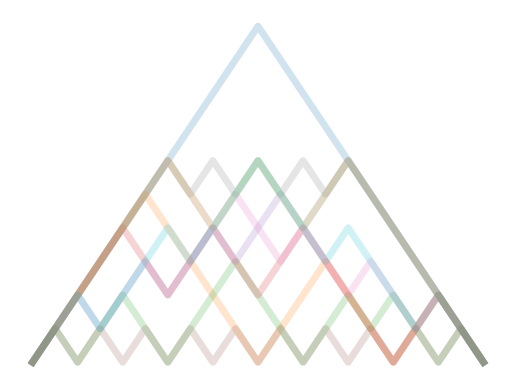

In [246]:
@typed
def prompt_from_template(temp: str) -> str:
    stack = []
    result = []
    for c in temp:
        if c == "(":
            bracket_type = np.random.randint(0, 250)
            stack.append(bracket_type)
            result.append(f"<{bracket_type + 1}")
        elif c == ")":
            bracket_type = stack.pop()
            result.append(f"{bracket_type + 1}>")
    return " ".join(result)


templates = [
    "(((((((((())))))))))",
    "((((()))))((()))(())",
    "()(())((()))(()())()",
    "(((())(())(())))(())",
    "(()(()(()(()(())))))",
    "()()()()()()()()()()",
    "(((((())())())())())",
    "(((((()()()()())))))",
    "(((((())(())(())))))",
    "(()((()((()))()))())",
]

for temp in templates:
    delta = np.array([0] + [c == "(" for c in temp])
    height = np.cumsum(2 * delta - 1)
    plt.plot(height, lw=5, alpha=0.2)
plt.axis("off")
plt.show()

In [ ]:
from utils import seed_everything

seed_everything(42)

prompts = []
for temp in templates:
    for _ in range(40):
        prompts.append(prompt_from_template(temp))

print(*prompts, sep="\n")

In [248]:
from utils import get_logprobs


@typed
def get_activations_for_single_prompt(
    model: nn.Module, tokenizer, prompt: str
) -> Float[TT, "seq_len d_total"]:
    global activations_dict
    activations_dict = {}
    with Hooks(model, activation_saver):
        model(**tokenizer(prompt, return_tensors="pt"))
    results = []
    activation = activations_dict[f"transformer.wte"].squeeze().detach()
    results.append(activation)
    last = activation
    for layer in range(8):
        activation = activations_dict[f"transformer.h.{layer}"][0].squeeze().detach()
        results.append(activation - last)
        last = activation
    logprobs = get_logprobs(model, tokenizer, prompt)[:, :500]
    results.append(logprobs.detach())
    return t.cat(results, dim=-1)


@typed
def get_activations_for_prompts(
    model: nn.Module, tokenizer, prompts: list[str]
) -> Float[TT, "n_prompts seq_len d_total"]:
    results = []
    for prompt in prompts:
        results.append(get_activations_for_single_prompt(model, tokenizer, prompt))
    return t.stack(results)


model_activations = get_activations_for_prompts(model, tokenizer, prompts)
print(model_activations.shape)
assert model_activations.shape[-1] == 9 * 256 + 500

d_model = 256

activations_map = {
    "wte": (0, d_model),
    "layer_0": (1 * d_model, 2 * d_model),
    "layer_1": (2 * d_model, 3 * d_model),
    "layer_2": (3 * d_model, 4 * d_model),
    "layer_3": (4 * d_model, 5 * d_model),
    "layer_4": (5 * d_model, 6 * d_model),
    "layer_5": (6 * d_model, 7 * d_model),
    "layer_6": (7 * d_model, 8 * d_model),
    "layer_7": (8 * d_model, 9 * d_model),
    "logprobs": (9 * d_model, 9 * d_model + 500),
}
print(activations_map)

torch.Size([400, 20, 2804])
{'wte': (0, 256), 'layer_0': (256, 512), 'layer_1': (512, 768), 'layer_2': (768, 1024), 'layer_3': (1024, 1280), 'layer_4': (1280, 1536), 'layer_5': (1536, 1792), 'layer_6': (1792, 2048), 'layer_7': (2048, 2304), 'logprobs': (2304, 2804)}


## Algorithm
Now we need a theoretical model of what is happening inside, as a function from some parameters to the dataset of targets with the shape `n_prompts seq_len n_targets`.

In [249]:
seed_everything(42)

n_types = 250
random_basis = t.randn((n_types, d_model))
random_basis /= random_basis.norm(dim=1, keepdim=True)
orthogonal_basis = t.zeros((n_types, d_model))
for i in range(n_types):
    orthogonal_basis[i, i] = 1


@typed
def run_algorithm(
    prompt: str,
    alpha_orth: Float[TT, ""],
    norms: Float[TT, "n_types"],
    depth_weights: Float[TT, "max_depth"],
) -> Float[TT, "seq_len n_targets"]:
    basis: Float[TT, "n_types d_model"] = (
        alpha_orth * orthogonal_basis + (1 - alpha_orth) * random_basis
    )
    basis *= norms.reshape(-1, 1)

    input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].squeeze()
    assert_type(input_ids, Int[TT, "seq"])
    is_open = (input_ids % 2 == 0).int()
    assert_type(is_open, Int[TT, "seq"])
    elevation = t.cumsum(2 * is_open - 1, dim=0) - is_open
    assert_type(elevation, Int[TT, "seq"])
    max_depth = t.tensor(depth_weights.shape[0] - 1)
    weight = depth_weights[t.minimum(elevation, max_depth)]
    assert_type(weight, Float[TT, "seq"])
    signed_weight = (2 * is_open - 1) * weight
    assert_type(signed_weight, Float[TT, "seq"])
    type_embeddings = basis[input_ids // 2]
    assert_type(type_embeddings, Float[TT, "seq d_model"])
    weighted_embeddings = signed_weight.unsqueeze(-1) * type_embeddings
    assert_type(weighted_embeddings, Float[TT, "seq d_model"])
    prefix_sums = t.cumsum(weighted_embeddings, dim=0)
    assert_type(prefix_sums, Float[TT, "seq d_model"])
    # normalize by sum of weights here?
    logits = prefix_sums @ basis.T
    assert_type(logits, Float[TT, "seq n_types"])
    logprobs = F.log_softmax(logits, dim=-1)
    assert_type(logprobs, Float[TT, "seq n_types"])

    targets = {
        "is_open": is_open.float().unsqueeze(-1),
        "elevation": elevation.float().unsqueeze(-1),
        "weight": weight.unsqueeze(-1),
        "signed_weight": signed_weight.unsqueeze(-1),
        "type_embeddings": type_embeddings,
        "weighted_embeddings": weighted_embeddings,
        "prefix_sums": prefix_sums,
        "logits": logits,
        "logprobs": logprobs,
    }
    return targets["weight"]


@typed
def run_algorithm_for_prompts(
    prompts: list[str],
    alpha_orth: Float[TT, ""],
    norms: Float[TT, "n_types"],
    depth_weights: Float[TT, "max_depth"],
) -> Float[TT, "n_prompts seq_len n_targets"]:
    results = []
    for prompt in prompts:
        results.append(run_algorithm(prompt, alpha_orth, norms, depth_weights))
    return t.stack(results)

In [273]:
alpha_orth = t.tensor(0.5)
norms = t.ones((n_types,))
max_depth = 16
depth_weights = 2.0 ** t.arange(max_depth)

targets = run_algorithm_for_prompts(prompts, alpha_orth, norms, depth_weights)
print(targets.shape)

torch.Size([400, 20, 1])


In [282]:
@typed
def build_datasets(
    model_part: str,
) -> tuple[Float[TT, "n_points d_X"], Float[TT, "n_points d_Y"]]:
    l, r = activations_map[model_part]
    X = ein.rearrange(
        model_activations.clone(),
        "n_prompts seq_len d_total -> (n_prompts seq_len) d_total",
    )[:, l:r]
    Y = ein.rearrange(
        targets.clone(), "n_prompts seq_len n_targets -> (n_prompts seq_len) n_targets"
    )

    # X = (X - X.mean()) / X.std()
    # Y = (Y - Y.mean()) / Y.std()

    return X, Y

In [283]:
from sklearn.linear_model import Ridge, Lasso

results = {}
for part in activations_map:
    X, Y = build_datasets(part)
    solver = Ridge(alpha=0.001).fit(X, Y)
    r2 = solver.score(X, Y)
    results[part] = r2
    print(part, r2)


wte 2.8186838418875482e-08
layer_0 0.776781807855271
layer_1 0.6927747677575433
layer_2 0.6453652660588945
layer_3 0.8642096038647055
layer_4 0.8129680498347946
layer_5 0.8462919789865612
layer_6 0.9204043772540644
layer_7 0.6612258240671044
logprobs 0.7892008314664376


In [307]:
X, Y = build_datasets("layer_6")
solver = Ridge(alpha=0.001).fit(X, Y)
print(solver.score(X, Y))

prompt = prompts[100]
activations_dict = {}
with Hooks(model, activation_saver):
    model(**tokenizer(prompt, return_tensors="pt"))
act6 = activations_dict["transformer.h.6"][0].squeeze().detach()
act5 = activations_dict["transformer.h.5"][0].squeeze().detach()
activations = act6 - act5

0.9204043772540644


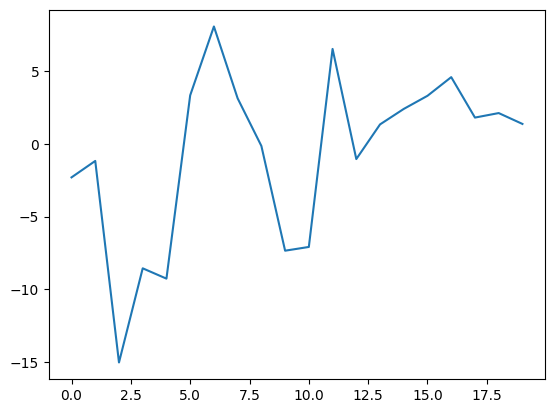

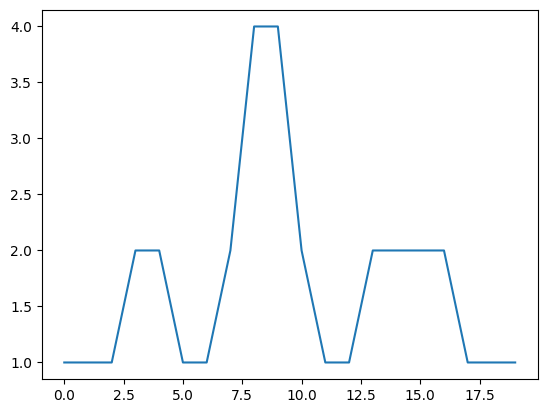

-50.96972023087548


In [308]:
pref = 20
x = activations
p = solver.predict(x)
y = run_algorithm(prompt, alpha_orth, norms, depth_weights)
plt.plot(p)
plt.show()
plt.plot(y)
plt.show()
print(solver.score(x, y))